# Import Libraries

In [1]:
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import networkx as nx
from itertools import combinations

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image, display

# Read Features

In [2]:
df = pd.read_csv("/home/yuxiao/nii_project/dataset/df/feature_data.csv")

df_plot = pd.read_csv("/home/yuxiao/nii_project/dataset/df/df_plot.csv")
df_plot["len"] = df_plot["char"].apply(lambda x: len(x))

In [5]:
df_1 = df_plot[df_plot["len"] == 1]
df_2 = df_plot[df_plot["len"] == 2]
df_3 = df_plot[df_plot["len"] == 3]
df_4 = df_plot[df_plot["len"] == 4]

## Similarity statistics

In [6]:
df_1.describe()

ssim  euclidean_distance        len
count  3.095378e+06        3.095378e+06  3095378.0
mean   6.766523e-01        2.765704e+00        1.0
std    1.552843e-01        1.139916e+00        0.0
min   -5.829338e-02        6.264561e-02        1.0
25%    5.803436e-01        1.973633e+00        1.0
50%    6.941016e-01        2.657800e+00        1.0
75%    7.916513e-01        3.441709e+00        1.0
max    9.998623e-01        9.375658e+00        1.0

In [7]:
df_2.describe()

ssim  euclidean_distance       len
count  235049.000000       235049.000000  235049.0
mean        0.732263            1.285081       2.0
std         0.129692            0.723622       0.0
min         0.181991            0.067856       2.0
25%         0.638458            0.684079       2.0
50%         0.731952            1.262684       2.0
75%         0.843377            1.733187       2.0
max         0.977147            4.834787       2.0

In [8]:
df_3.describe()

ssim  euclidean_distance      len
count  12617.000000        12617.000000  12617.0
mean       0.760793            0.947216      3.0
std        0.141269            0.737297      0.0
min        0.274145            0.057807      3.0
25%        0.644479            0.341424      3.0
50%        0.801380            0.620994      3.0
75%        0.885208            1.502173      3.0
max        0.973664            3.537054      3.0

In [9]:
df_4.describe()

ssim  euclidean_distance     len
count  1085.000000         1085.000000  1085.0
mean      0.747652            0.805187     4.0
std       0.131072            0.551647     0.0
min       0.349701            0.085817     4.0
25%       0.633330            0.327980     4.0
50%       0.762163            0.682236     4.0
75%       0.871258            1.179855     4.0
max       0.949828            2.488685     4.0

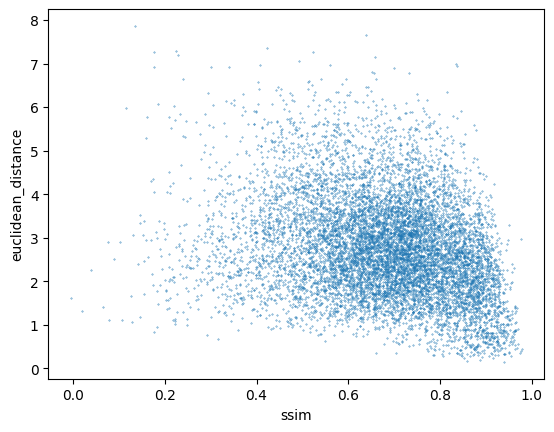

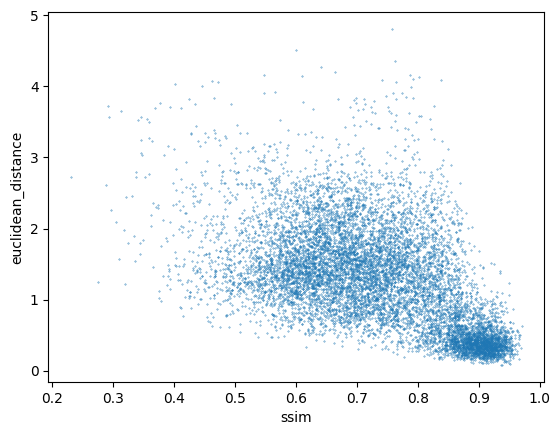

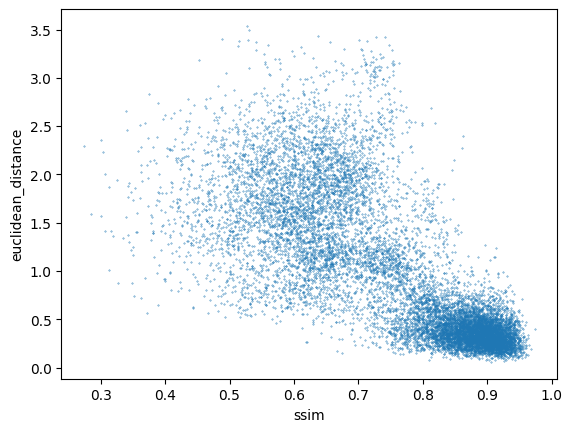

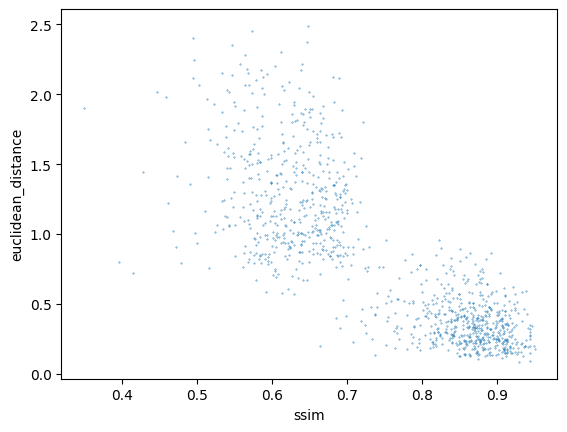

In [10]:
# similarity score plots
ax1 = df_1.sample(10000).plot.scatter(x="ssim", y="euclidean_distance", s=0.1)
ax2 = df_2.sample(10000).plot.scatter(x="ssim", y="euclidean_distance", s=0.1)
ax3 = df_3.plot.scatter(x="ssim", y="euclidean_distance", s=0.1)
ax4 = df_4.plot.scatter(x="ssim", y="euclidean_distance", s=0.1)

## Graph Clustering

In [4]:
label_list = df_plot["label"].unique()
book_list = [pd.DataFrame() for _ in label_list]

In [11]:
for i in tqdm(range(len(label_list))):
    edge = df_plot[df_plot["label"] == label_list[i]].rename(
        columns={"image1": "source", "image2": "target"}
    )

    G = nx.Graph()
    G = nx.from_pandas_edgelist(
        edge, "source", "target", ["ssim", "euclidean_distance", "len", "char"]
    )
    edges_to_remove = []
    for u, v, attributes in G.edges(data=True):
        distance = attributes.get("euclidean_distance")
        ssim = attributes.get("ssim")
        char_length = attributes.get("len")
        _, _, upage1, upage2 = u[:-4].split("_")
        _, _, vpage1, vpage2 = v[:-4].split("_")
        if (upage1 == vpage1) and (upage2 == vpage2):
            edges_to_remove.append((u, v))
        if char_length == 1:
            if not ((distance < 0.75) and (ssim > 0.7)):
                edges_to_remove.append((u, v))
        else:
            if not ((distance < 0.5) and (ssim > 0.7)):
                edges_to_remove.append((u, v))

    G.remove_edges_from(edges_to_remove)

    connected_components = nx.connected_components(G)
    label, img_no, book_no, page1_no, page2_no, image_path = [], [], [], [], [], []
    for idx, component in enumerate(connected_components):
        for element in component:
            a, b, c, d = element[:-4].split("_")
            label.append(idx)
            img_no.append(a)
            book_no.append(b)
            page1_no.append(c)
            page2_no.append(d)
            image_path.append(element)

    book_list[i] = pd.DataFrame(
        list(zip(label, img_no, book_no, page1_no, page2_no, image_path)),
        columns=["label", "img_no", "book_no", "page1_no", "page2_no", "image_path"],
    )
    book_list[i]["jibo"] = label_list[i]

100%|██████████| 2170/2170 [06:07<00:00,  5.91it/s]


## Statistics Plots

In [44]:
# single_block_jibo = book.groupby(["jibo", "label"]).size().to_frame().groupby("jibo").size()[book.groupby(["jibo", "label"]).size().to_frame().groupby("jibo").size() == 1].index
# book.loc[book["jibo"].isin(single_block_jibo), "label"] = -1
# book["page_no"] = book["page1_no"] +"_"+ book["page2_no"]

# Combine the list of DataFrames into a single DataFrame
book = pd.concat(book_list)

# Group data by "jibo" and "label", then count occurrences
grouped_counts = book.groupby(["jibo", "label"]).size().to_frame(name="count")

# Identify "jibo" values with only one unique "label" value
single_label_jibo = (
    grouped_counts.groupby("jibo")
    .size()[grouped_counts.groupby("jibo").size() == 1]
    .index
)

# Update "label" column for rows with "jibo" values having only one unique "label"
book.loc[book["jibo"].isin(single_label_jibo), "label"] = -1

# Create a new "page_no" column by concatenating "page1_no" and "page2_no"
book["page_no"] = book["page1_no"] + "_" + book["page2_no"]

In [45]:
# book["block"] = book["jibo"] + book["label"].apply(lambda x: str(x))
# only_block = book.groupby("block").size()[book.groupby("block").size() == 1]

# Create a new column "block" by concatenating "jibo" and "label"
book["block"] = book["jibo"] + book["label"].astype(str)

# Count occurrences of each "block" and filter blocks with only one occurrence
only_block = book["block"].value_counts()[book["block"].value_counts() == 1].index

# Filter rows with block values in 'only_block'
book_only_block = book[book["block"].isin(only_block)]

# Use boolean indexing for better readability
book_one_block = book[book["label"] == -1]
book_recurrent_block = book[book["label"] != -1]

In [46]:
# Group by "jibo" and "label", then calculate the size
grouped_cluster_size = (
    book.groupby(["jibo", "label"])
    .size()
    .to_frame()
    .groupby("jibo")
    .size()
    .to_frame(name="cluster_number")
    .groupby("cluster_number")
    .size()
    .sort_values()
)
grouped_size_count = grouped_cluster_size.to_frame(name="count").reset_index()

In [19]:
len(np.unique(book.jibo))

2170

In [48]:
# Calculate the weighted sum
weighted_sum = (
    grouped_size_count["cluster_number"] * grouped_size_count["count"]
).sum()
weighted_sum

7299

In [50]:
book.groupby(["jibo", "label"]).size().to_frame().groupby("jibo").size().to_frame(
    name="cluster_number"
).sort_values("cluster_number", ascending=False).head(10)

cluster_number
jibo                
能                153
八                134
尓                129
遠                127
毛                122
天                116
止                 68
以                 58
乃                 55
比                 53

In [52]:
# Group by "jibo" and "label", then calculate the size and reset index
grouped_jibo_block_size = (
    book.groupby(["jibo", "label"]).size().reset_index(name="count")
)

# Group by "jibo", calculate the number of clusters, sort, and select top 10
jibo_with_most_cluster = (
    grouped_jibo_block_size.groupby("jibo")
    .size()
    .reset_index(name="cluster_number")
    .sort_values(by="cluster_number", ascending=False)
    .head(10)
)

jibo_with_most_cluster

jibo  cluster_number
1832    能             153
355     八             134
938     尓             129
2013    遠             127
1536    毛             122
673     天             116
1455    止              68
222     以              58
95      乃              55
1520    比              53

In [53]:
# Filter clusters with cluster_number <= 15 and sort
grouped_size_count_1 = grouped_size_count[
    grouped_size_count["cluster_number"] <= 15
].sort_values("cluster_number")

# Convert cluster_number to strings
grouped_size_count_1["cluster_number"] = grouped_size_count_1["cluster_number"].astype(
    str
)

# Calculate sum of counts for clusters with cluster_number > 15
grouped_size_count_2 = {
    "cluster_number": ">15",
    "count": grouped_size_count.loc[
        grouped_size_count["cluster_number"] > 15, "count"
    ].sum(),
}

# Create a DataFrame for clusters with cluster_number > 15
grouped_size_count_2_df = pd.DataFrame([grouped_size_count_2])

# Concatenate the DataFrames
new_grouped_size_count = pd.concat(
    [grouped_size_count_1, grouped_size_count_2_df], ignore_index=True
)

# Convert cluster_number to strings
new_grouped_size_count["cluster_number"] = new_grouped_size_count[
    "cluster_number"
].astype(str)

In [56]:
# Filter clusters with cluster_number > 15
filtered_clusters = grouped_size_count[grouped_size_count["cluster_number"] > 15].copy()

# Calculate the weighted sum
weighted_sum = (filtered_clusters["cluster_number"] * filtered_clusters["count"]).sum()
weighted_sum

2042

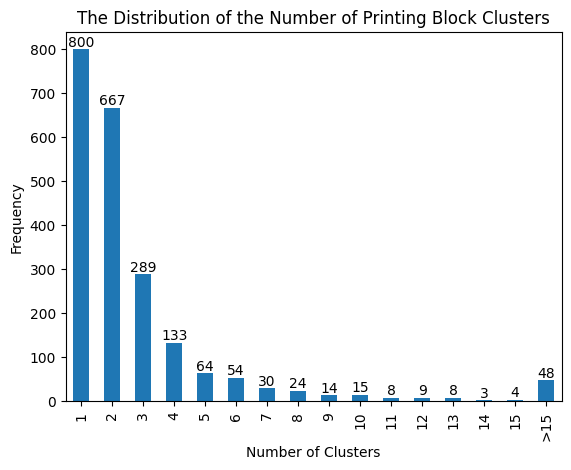

In [57]:
# Create a bar plot for the count distribution
ax = new_grouped_size_count.plot(
    kind="bar", x="cluster_number", y="count", legend=False
)

# Annotate bars with their corresponding values
for idx, value in enumerate(new_grouped_size_count["count"]):
    ax.text(idx, value, str(value), ha="center", va="bottom")

plt.title("The Distribution of the Number of Printing Block Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.show()

In [60]:
block_size_count = (
    book.groupby("block").size().sort_values(ascending=False).reset_index(name="count1")
)

In [61]:
block_size_count.head(10)

block  count1
0    天0     547
1    八1     367
2    可0     285
3    止2     217
4    尓6     212
5    乃1     198
6    人0     193
7    之0     154
8    遠1     149
9    曽0     135

In [62]:
count_summary = char_count.groupby("count1").size().reset_index(name="count2")

In [66]:
# grouped_block_size_count_1 = count_summary.loc[temp_df["count1"] <= 20].sort_values("count1")
# grouped_block_size_count_1["count1"] = grouped_block_size_count_1["count1"].astype(str)
# grouped_block_size_count_2 = {"count1": ">21", "count2": temp_df.loc[temp_df["count1"] > 20, "count2"].sum()}

# new_grouped_block_size_count = pd.concat([grouped_block_size_count_1, pd.DataFrame(grouped_block_size_count_2, index=[0])], ignore_index=True)
# new_grouped_block_size_count["count1"] = new_grouped_block_size_count["count1"].astype(str)
# Filter counts with count1 <= 20 and sort
grouped_block_size_count_1 = count_summary[count_summary["count1"] <= 20].sort_values(
    "count1"
)

# Convert count1 to strings
grouped_block_size_count_1["count1"] = grouped_block_size_count_1["count1"].astype(str)

# Calculate sum of count2 for counts with count1 > 20
grouped_block_size_count_2 = {
    "count1": ">21",
    "count2": count_summary.loc[count_summary["count1"] > 20, "count2"].sum(),
}

# Create a DataFrame for counts with count1 > 20
grouped_block_size_count_2_df = pd.DataFrame([grouped_block_size_count_2])

# Concatenate the DataFrames
new_grouped_block_size_count = pd.concat(
    [grouped_block_size_count_1, grouped_block_size_count_2_df], ignore_index=True
)

# Convert count1 to strings
new_grouped_block_size_count["count1"] = new_grouped_block_size_count["count1"].astype(
    str
)

In [68]:
# Filter counts with count1 > 20 and sort
filtered_counts = temp_df[temp_df["count1"] > 20].sort_values("count1")

# Calculate the weighted sum
weighted_sum = (filtered_counts["count1"] * filtered_counts["count2"]).sum()
weighted_sum

9720

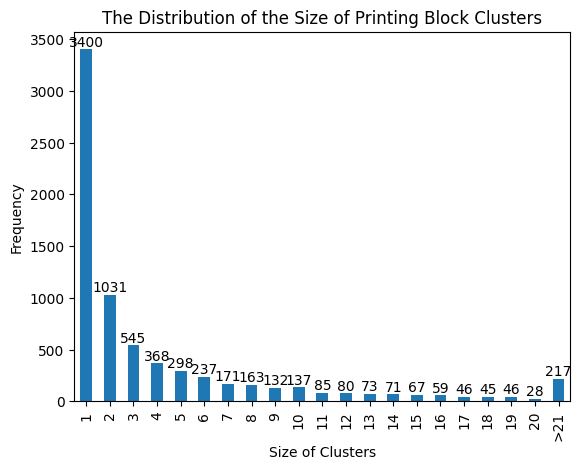

In [69]:
# Create a bar plot for the count distribution
ax = new_grouped_block_size_count.plot(kind="bar", x="count1", y="count2", legend=False)

# Annotate bars with their corresponding values
for idx, value in enumerate(new_grouped_block_size_count["count2"]):
    ax.text(idx, value, str(value), ha="center", va="bottom")

plt.title("The Distribution of the Size of Printing Block Clusters")
plt.xlabel("Size of Clusters")
plt.ylabel("Frequency")
plt.show()

## Wrong Cases Check(same printing block but in same page)

In [28]:
page_check = (
    book.groupby(["block", "page_no"])
    .size()
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
    .rename(columns={0: "count"})
)

In [70]:
page_check[page_check["count"] > 1].head(20)

block page_no  count
0     天0    38_0      7
1     天0   109_1      7
2     天0   157_1      6
3     天0    96_1      6
4     天0    37_1      6
5     天0   166_0      6
6     一0   132_0      6
7     八1   150_0      5
8     天0    60_0      5
9     天0    28_1      5
10    天0    64_0      5
11    天0   169_0      5
12    天0    42_1      5
13    申2   153_1      5
14    可0   120_1      5
15    尓6    83_0      5
16    天0    35_0      5
17    天0   121_1      5
18    天0    48_1      5
19    天0   122_1      5

## Generate Training Data from wrong cases

In [19]:
def generate_unique_pairs(word_list):
    result = []
    for pair in combinations(word_list, 2):
        result.append(pair)
    return result

In [20]:
neg_df = []

In [21]:
for idx, row in page_check[page_check["count"] > 1].iterrows():
    unique_pairs = generate_unique_pairs(
        book[(book["page_no"] == row.page_no) & (book["block"] == row.block)].image_path
    )
    for pair in unique_pairs:
        neg_df.append(list(pair))

In [22]:
len(neg_df)

1707

In [23]:
# List of words
words = book[(book["page_no"] == row.page_no) & (book["block"] == row.block)].image_path

# Generate unique pairs of words
unique_pairs = generate_unique_pairs(words)

# Print the list of unique pairs
for pair in unique_pairs:
    print(list(pair))

['35076_001_91_1.jpg', '35120_001_91_1.jpg']


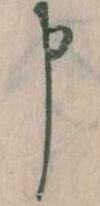

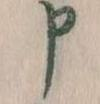

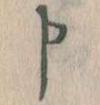

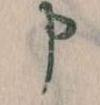

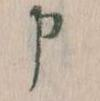

In [71]:
for idx, row in book[(book["page_no"] == "153_1") & (book["block"] == "申2")].iterrows():
    display(Image(filename=f"../dataset/1/{row.image_path}"))

In [ ]:
how many paper it appeared

no blocks/no pages

no blocks/no clusters

no of clusters / no 

cluster(prox)==printingblock

character sequence : あ、あお。。。。

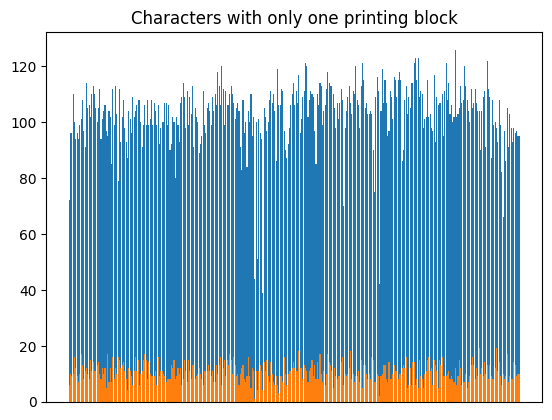

In [26]:
plt.bar(x=book.groupby("page_no").size().index, height=book.groupby("page_no").size())
plt.bar(
    x=book_one_block.groupby("page_no").size().index,
    height=book_one_block.groupby("page_no").size(),
)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.title("Characters with only one printing block")
plt.show()

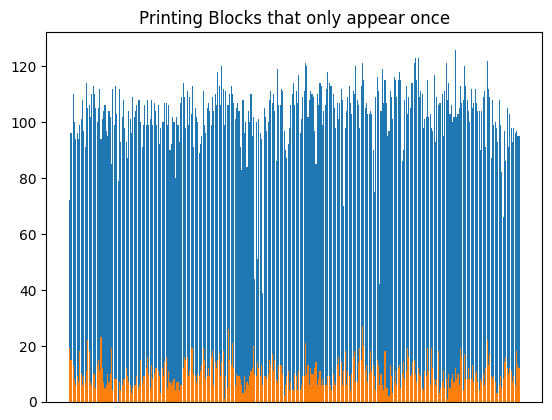

In [27]:
plt.bar(x=book.groupby("page_no").size().index, height=book.groupby("page_no").size())
plt.bar(
    x=book_only_block.groupby("page_no").size().index,
    height=book_only_block.groupby("page_no").size(),
)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.title("Printing Blocks that only appear once")
plt.show()

In [103]:
df_plot[df_plot["len"] == 1].groupby("label").size().sort_values(ascending=False).head(
    30
).index

Index(['天', '尓', '能', '遠', '八', '毛', '人', '乃', '止', '幾', '可', '仁', '事', '越',
       '以', '登', '也', '左', '末', '久', '己', '之', '濃', '須', '心', '女', '部', '奴',
       '宇', '安'],
      dtype='object', name='label')

In [ ]:
for jibo in (
    df_plot[df_plot["len"] == 1]
    .groupby("jibo")
    .size()
    .sort_values(ascending=False)
    .head(30)
    .index
):
    print(jibo)
    print(df_plot[df_plot["jibo"] == jibo][["euclidean_distance"]].quantile(0.25))

In [72]:
edge = df_plot[df_plot["label"] == "申"]
edge.describe()

ssim  euclidean_distance     len
count  4371.000000         4371.000000  4371.0
mean      0.814256            1.460568     1.0
std       0.080864            0.634228     0.0
min       0.422905            0.166210     1.0
25%       0.778092            1.010289     1.0
50%       0.825027            1.426757     1.0
75%       0.865907            1.846159     1.0
max       0.968278            4.044803     1.0

In [73]:
edge[["euclidean_distance"]].quantile(0.1)

euclidean_distance    0.64347
Name: 0.1, dtype: float64

<Axes: xlabel='ssim', ylabel='euclidean_distance'>

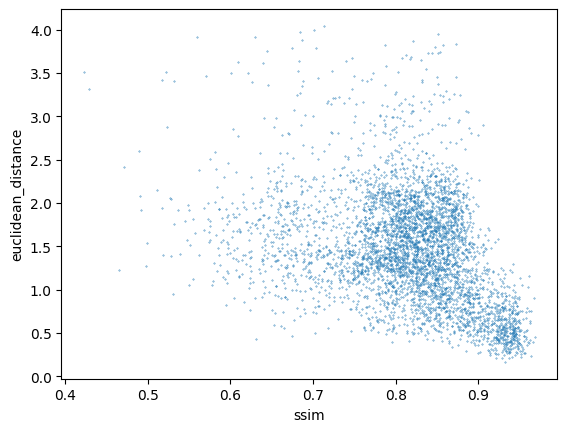

In [74]:
edge.plot.scatter(x="ssim", y="euclidean_distance", s=0.1)

In [75]:
edge = edge.rename(columns={"image1": "source", "image2": "target"})
edge.head()

source              target char label      ssim   
2573348  1492_001_106_1.jpg  1567_001_106_1.jpg    申     申  0.747793  \
2573349  1492_001_106_1.jpg  2138_001_109_0.jpg    申     申  0.841760   
2573350  1492_001_106_1.jpg  2840_001_111_1.jpg    申     申  0.858959   
2573351  1492_001_106_1.jpg  2854_001_111_1.jpg    申     申  0.911021   
2573352  1492_001_106_1.jpg  2900_001_111_1.jpg    申     申  0.763941   

         euclidean_distance  len  
2573348            2.265008    1  
2573349            2.313789    1  
2573350            2.042966    1  
2573351            1.706537    1  
2573352            1.458756    1

In [83]:
G = nx.Graph()

# Read the edge list from the Pandas DataFrame
G = nx.from_pandas_edgelist(
    edge, "source", "target", ["ssim", "euclidean_distance", "len", "char"]
)

In [84]:
edges_to_remove = []
for u, v, attributes in G.edges(data=True):
    distance = attributes.get("euclidean_distance")
    ssim = attributes.get("ssim")
    if not ((distance < 0.5) and (ssim > 0.7)):
        edges_to_remove.append((u, v))

In [85]:
# Remove edges that meet the condition
G.remove_edges_from(edges_to_remove)

In [86]:
book = pd.DataFrame(
    list(zip(label, img_no, book_no)), columns=["label", "img_no", "book_no"]
)

{'1492_001_106_1.jpg'}


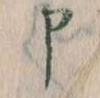

--------
{'1567_001_106_1.jpg'}


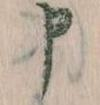

--------
{'12926_001_154_0.jpg', '12726_001_153_1.jpg', '31137_001_75_1.jpg', '32750_001_81_1.jpg', '6454_001_127_1.jpg', '3070_001_112_1.jpg', '15386_001_165_0.jpg', '34410_001_89_1.jpg', '26428_001_57_0.jpg', '35442_001_93_0.jpg', '18709_001_24_1.jpg', '28818_001_66_0.jpg', '32589_001_81_0.jpg', '23873_001_46_0.jpg', '2138_001_109_0.jpg', '12491_001_152_0.jpg', '9970_001_142_0.jpg'}


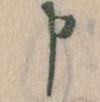

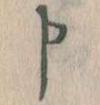

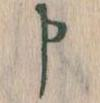

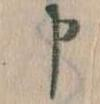

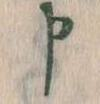

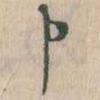

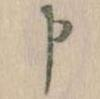

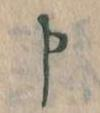

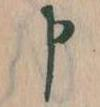

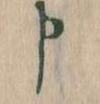

--------
{'35279_001_92_1.jpg', '31163_001_75_1.jpg', '33441_001_85_0.jpg', '10213_001_143_0.jpg', '12782_001_153_1.jpg', '8071_001_134_0.jpg', '2840_001_111_1.jpg', '4166_001_117_1.jpg'}


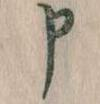

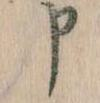

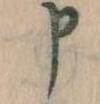

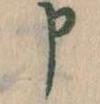

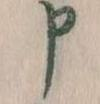

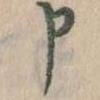

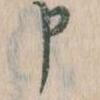

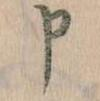

--------
{'23372_001_43_1.jpg', '3038_001_112_1.jpg', '35165_001_92_0.jpg', '10963_001_146_1.jpg', '11633_001_149_1.jpg', '26916_001_59_0.jpg', '12906_001_154_0.jpg', '24161_001_47_0.jpg', '12288_001_151_1.jpg', '2900_001_111_1.jpg', '6701_001_128_1.jpg', '31796_001_78_1.jpg', '6562_001_128_0.jpg', '31824_001_78_1.jpg', '7214_001_130_0.jpg', '6341_001_127_0.jpg', '33604_001_85_1.jpg', '35502_001_93_1.jpg', '11136_001_147_1.jpg', '12376_001_152_0.jpg', '2854_001_111_1.jpg', '12787_001_153_1.jpg', '19202_001_27_0.jpg', '20526_001_32_0.jpg'}


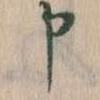

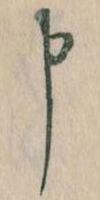

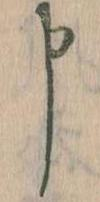

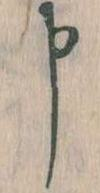

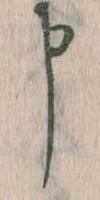

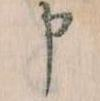

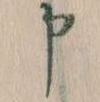

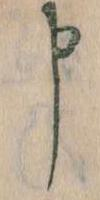

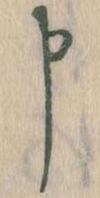

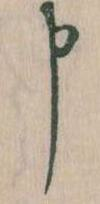

--------
{'35379_001_93_0.jpg', '6850_001_129_1.jpg', '10078_001_142_1.jpg', '32553_001_81_0.jpg', '3523_001_114_1.jpg', '6609_001_128_0.jpg', '31200_001_76_0.jpg', '35184_001_92_0.jpg', '20642_001_32_1.jpg', '35545_001_93_1.jpg', '28662_001_65_1.jpg', '12774_001_153_1.jpg', '23941_001_46_0.jpg', '13592_001_157_0.jpg'}


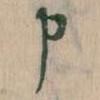

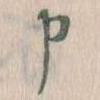

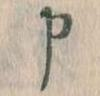

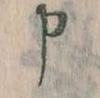

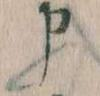

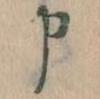

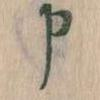

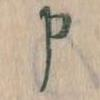

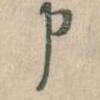

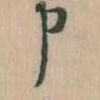

--------
{'13561_001_157_0.jpg', '12791_001_153_1.jpg', '35225_001_92_0.jpg', '35478_001_93_1.jpg', '7205_001_130_0.jpg', '6394_001_127_0.jpg'}


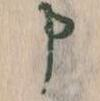

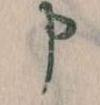

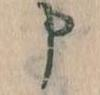

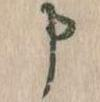

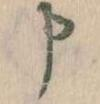

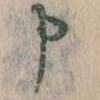

--------
{'9539_001_140_0.jpg'}


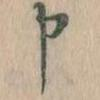

--------
{'10329_001_143_1.jpg'}


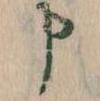

--------
{'11040_001_147_0.jpg', '12171_001_151_0.jpg', '15735_001_167_0.jpg', '23700_001_45_0.jpg', '26907_001_59_0.jpg'}


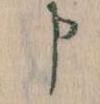

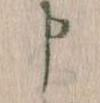

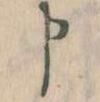

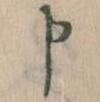

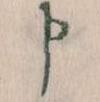

--------
{'11101_001_147_0.jpg'}


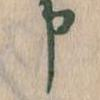

--------
{'20695_001_32_1.jpg', '13019_001_154_1.jpg'}


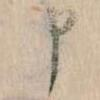

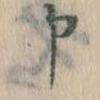

--------
{'15373_001_165_0.jpg'}


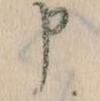

--------
{'18615_001_24_1.jpg'}


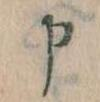

--------
{'26318_001_56_1.jpg'}


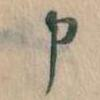

--------
{'27085_001_59_1.jpg'}


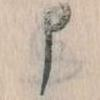

--------
{'29079_001_67_1.jpg'}


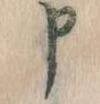

--------
{'29389_001_68_1.jpg'}


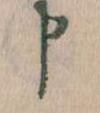

--------
{'31759_001_78_1.jpg', '35370_001_93_0.jpg'}


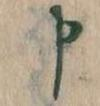

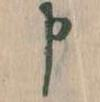

--------
{'31943_001_79_0.jpg'}


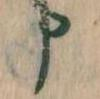

--------
{'31950_001_79_0.jpg'}


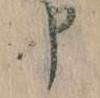

--------
{'33535_001_85_1.jpg'}


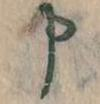

--------
{'35160_001_92_0.jpg'}


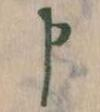

--------
{'35269_001_92_1.jpg'}


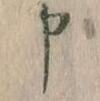

--------


In [87]:
connected_components = nx.connected_components(G)

label, img_no, book_no, page_no = [], [], [], []
for idx, component in enumerate(connected_components):
    print(component)
    count = 0
    for element in component:
        label.append(idx)
        img_no.append(element.split("_")[0])
        book_no.append(element.split("_")[1])
        display(Image(filename=f"../dataset/1/{element}"))
        count += 1
        if count == 10:
            break
    print("--------")

In [ ]:
connected_components = nx.connected_components(G)

label, img_no, book_no, page_no = [], [], [], []
for idx, component in enumerate(connected_components):
    print(component)
    for element in component:
        label.append(idx)
        img_no.append(element.split("_")[0])
        book_no.append(element.split("_")[1])
        page_no.append(element.split("_")[2])
        display(Image(filename=f"../dataset/1/{element}"))
    print("--------")

In [ ]:
df_plot[
    (df_plot["image1"] == "11869_001_14_1.jpg")
    & (df_plot["image2"] == "13572_001_157_0.jpg")
]

## Image pair selection

In [ ]:
df_new = pd.read_csv("/home/yuxiao/nii_project/dataset/df/feature_data_2_new.csv")
df_new["block"] = df_new["label"] + df_new["block"].apply(lambda x: "_" + str(int(x)))
df_new.groupby(["label", "block"]).size()

In [ ]:
label_list = np.unique(df.label)
df["block"] = np.nan

In [ ]:
def char_is_hiragana(c) -> bool:
    return "\u3040" <= c <= "\u309F"


df_new[df["jibo"].apply(lambda x: len(x) == 1 and char_is_hiragana(x))]["jibo"].unique()

In [ ]:
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    if len(char) == 2:
        for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
            img1 = transformation(transform, "../dataset/2/" + row1.image_file).to(
                device
            )
            for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
                if idx2 > idx1 and count < 5:
                    img2 = transformation(
                        transform, "../dataset/2/" + row2.image_file
                    ).to(device)
                    output1, output2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
                    euclidean_distance = F.pairwise_distance(output1, output2)
                    sim_score = computer_sim_score(
                        "../dataset/2/" + row1.image_file,
                        "../dataset/2/" + row2.image_file,
                    )
                    # if (
                    #     ((0.5 < euclidean_distance < 1.5) and (0.75 < sim_score < 0.95))
                    #     or (1 < euclidean_distance < 0.5)
                    #     or (0.9 < sim_score < 0.95)
                    # ):
                    # if (0.8 < sim_score < 0.85):
                    if (euclidean_distance > 2) and (sim_score < 0.5):
                        count += 1
                        fig = plt.figure()
                        ax1 = fig.add_subplot(2, 2, 1)
                        ax1.imshow(img1[0].cpu())
                        ax2 = fig.add_subplot(2, 2, 2)
                        ax2.imshow(img2[0].cpu())

                        plt.show()
                        break
    if i > 100:
        break

In [ ]:
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    if len(char) == 2:
        for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
            img1 = transformation(transform, "../dataset/2/" + row1.image_file).to(
                device
            )
            for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
                if idx2 > idx1 and count < 5:
                    img2 = transformation(
                        transform, "../dataset/2/" + row2.image_file
                    ).to(device)
                    output1, output2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
                    euclidean_distance = F.pairwise_distance(output1, output2)
                    sim_score = computer_sim_score(
                        "../dataset/2/" + row1.image_file,
                        "../dataset/2/" + row2.image_file,
                    )
                    # if (
                    #     ((0.5 < euclidean_distance < 1.5) and (0.75 < sim_score < 0.95))
                    #     or (1 < euclidean_distance < 0.5)
                    #     or (0.9 < sim_score < 0.95)
                    # ):
                    # if (0.8 < sim_score < 0.85):
                    if (euclidean_distance < 0.5) and (sim_score < 0.8):
                        count += 1
                        fig = plt.figure()
                        ax1 = fig.add_subplot(2, 2, 1)
                        ax1.imshow(img1[0].cpu())
                        ax2 = fig.add_subplot(2, 2, 2)
                        ax2.imshow(img2[0].cpu())

                        plt.show()
                        break
    if i > 100:
        break

In [ ]:
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    if len(char) == 2:
        for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
            img1 = transformation(transform, "../dataset/2/" + row1.image_file).to(
                device
            )
            for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
                if idx2 > idx1 and count < 5:
                    img2 = transformation(
                        transform, "../dataset/2/" + row2.image_file
                    ).to(device)
                    output1, output2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
                    euclidean_distance = F.pairwise_distance(output1, output2)
                    sim_score = computer_sim_score(
                        "../dataset/2/" + row1.image_file,
                        "../dataset/2/" + row2.image_file,
                    )
                    # if (
                    #     ((0.5 < euclidean_distance < 1.5) and (0.75 < sim_score < 0.95))
                    #     or (1 < euclidean_distance < 0.5)
                    #     or (0.9 < sim_score < 0.95)
                    # ):
                    # if (0.8 < sim_score < 0.85):
                    if (euclidean_distance < 0.5) and (sim_score < 0.8):
                        count += 1
                        fig = plt.figure()
                        ax1 = fig.add_subplot(2, 2, 1)
                        ax1.imshow(img1[0].cpu())
                        ax2 = fig.add_subplot(2, 2, 2)
                        ax2.imshow(img2[0].cpu())

                        plt.show()
                        break
    if i > 100:
        break

In [ ]:
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    if len(char) == 2:
        for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
            img1 = transformation(transform, "../dataset/2/" + row1.image_file).to(
                device
            )
            for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
                if idx2 > idx1 and count < 5:
                    img2 = transformation(
                        transform, "../dataset/2/" + row2.image_file
                    ).to(device)
                    output1, output2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
                    euclidean_distance = F.pairwise_distance(output1, output2)
                    sim_score = computer_sim_score(
                        "../dataset/2/" + row1.image_file,
                        "../dataset/2/" + row2.image_file,
                    )
                    # if (
                    #     ((0.5 < euclidean_distance < 1.5) and (0.75 < sim_score < 0.95))
                    #     or (1 < euclidean_distance < 0.5)
                    #     or (0.9 < sim_score < 0.95)
                    # ):
                    # if (0.8 < sim_score < 0.85):
                    if (euclidean_distance > 1.5) and (sim_score > 0.8):
                        count += 1
                        fig = plt.figure()
                        ax1 = fig.add_subplot(2, 2, 1)
                        ax1.imshow(img1[0].cpu())
                        ax2 = fig.add_subplot(2, 2, 2)
                        ax2.imshow(img2[0].cpu())

                        plt.show()
                        break
    if i > 200:
        break

In [ ]:
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
        img1 = transformation(transform, "../dataset/2/" + row1.image_file).to(device)
        for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
            if idx2 > idx1 and count < 5:
                img2 = transformation(transform, "../dataset/2/" + row2.image_file).to(
                    device
                )
                output1, output2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
                euclidean_distance = F.pairwise_distance(output1, output2)
                sim_score = computer_sim_score(
                    "../dataset/2/" + row1.image_file,
                    "../dataset/2/" + row2.image_file,
                )
                # if (
                #     ((0.5 < euclidean_distance < 1.5) and (0.75 < sim_score < 0.95))
                #     or (1 < euclidean_distance < 0.5)
                #     or (0.9 < sim_score < 0.95)
                # ):
                # if (0.8 < sim_score < 0.85):
                if (euclidean_distance > 1.5) and (sim_score > 0.7):
                    count += 1
                    fig = plt.figure()
                    ax1 = fig.add_subplot(2, 2, 1)
                    ax1.imshow(img1[0].cpu())
                    ax2 = fig.add_subplot(2, 2, 2)
                    ax2.imshow(img2[0].cpu())

                    plt.show()
                    break
    if i > 50:
        break

In [ ]:
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    if len(char) == 1:
        for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
            img1 = transformation(transform, "../dataset/2/" + row1.image_file).to(
                device
            )
            for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
                if idx2 > idx1 and count < 5:
                    img2 = transformation(
                        transform, "../dataset/2/" + row2.image_file
                    ).to(device)
                    output1, output2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
                    euclidean_distance = F.pairwise_distance(output1, output2)
                    sim_score = computer_sim_score(
                        "../dataset/2/" + row1.image_file,
                        "../dataset/2/" + row2.image_file,
                    )
                    # if (
                    #     ((0.5 < euclidean_distance < 1.5) and (0.75 < sim_score < 0.95))
                    #     or (1 < euclidean_distance < 0.5)
                    #     or (0.9 < sim_score < 0.95)
                    # ):
                    # if (0.8 < sim_score < 0.85):
                    if (euclidean_distance < 0.5) and (sim_score < 0.8):
                        count += 1
                        fig = plt.figure()
                        ax1 = fig.add_subplot(2, 2, 1)
                        ax1.imshow(img1[0].cpu())
                        ax2 = fig.add_subplot(2, 2, 2)
                        ax2.imshow(img2[0].cpu())

                        plt.show()
                        break
    if i > 200:
        break